In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
file_path = "/Users/soardr/QPoland 2026 hackathon/Macroscopic-Quantum-Tunneling-main/Notebooks/synthetic_junction_data__escape_prob.csv"

In [3]:
data = pd.read_csv(file_path)
print("Dataset shape:", data.shape)
print("Columns:", data.columns)

Dataset shape: (125, 503)
Columns: Index(['EJ', 'm', 'I_over_Ic', 'ep_t0', 'ep_t1', 'ep_t2', 'ep_t3', 'ep_t4',
       'ep_t5', 'ep_t6',
       ...
       'ep_t490', 'ep_t491', 'ep_t492', 'ep_t493', 'ep_t494', 'ep_t495',
       'ep_t496', 'ep_t497', 'ep_t498', 'ep_t499'],
      dtype='object', length=503)


### viz

In [4]:
# pd.plotting.scatter_matrix(data, figsize=(10, 8))
# plt.show()

In [160]:
X = data.iloc[:, :3].values
y = data.iloc[:, 3:].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
def create_rnn_data(params, sequences):
    N, T = sequences.shape
    X = []
    y = []

    for i in range(N):
        p = np.repeat(params[i][np.newaxis, :], T-1, axis=0)   # repeat params across time
        prev_y = sequences[i, :-1].reshape(-1, 1)              # y_{t-1}
        next_y = sequences[i, 1:].reshape(-1, 1)               # y_t

        X.append(np.hstack([p, prev_y]))  # shape (T-1, 4)
        y.append(next_y)                  # shape (T-1, 1)

    return np.array(X), np.array(y)

In [10]:
X_train_seq, y_train_seq = create_rnn_data(X_train, y_train)
X_test_seq, y_test_seq = create_rnn_data(X_test, y_test)

In [12]:
print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(100, 499, 4) (100, 499, 1)
(25, 499, 4) (25, 499, 1)


In [98]:
model = models.Sequential([
    layers.Input(shape=(None, 4)),   # (time, features)
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.Dense(1)
])

In [99]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, None, 32)       │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, None, 32)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,089 (51.13 KB)

 Trainable params: 13,089 (51.13 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0409 - val_loss: 0.0335
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0224 - val_loss: 0.0322
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0202 - val_loss: 0.0258
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0169 - val_loss: 0.0223
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0165 - val_loss: 0.0224
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0160 - val_loss: 0.0219
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0155 - val_loss: 0.0201
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0151 - val_loss: 0.0199
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0148 - val_loss: 0.0190
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0145 - val_loss: 0.0183
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0141 - val_loss: 0.0175
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0138 - val_loss: 0.

In [101]:
def predict_sequence(model, params, y0, seq_len=500):
    y_pred = [y0]
    y_prev = y0

    for t in range(seq_len - 1):
        # print(params, y_prev)
        x_input = np.hstack([params, y_prev]).reshape(1, 1, 4)
        # print(t, x_input)
        y_next = model.predict(x_input, verbose=0)[0, 0, 0]
        y_pred.append(y_next)
        y_prev = np.array(y_next)

        # print(y_next)
        # print(y_pred)
        # print(y_prev)
    
    print(y_pred)

    return np.array(y_pred)

In [102]:
sample_params = X_train[0]
initial_y = y_train[0, 0]  # starting value

In [103]:
sample_params, initial_y

(array([0.75 , 0.775, 0.895]), np.float64(2.115923499858663e-09))

In [104]:
predicted_seq = predict_sequence(model, sample_params, initial_y)

print(predicted_seq.shape)  # (500,)

[np.float64(2.115923499858663e-09), np.float32(0.10376293), np.float32(0.10510555), np.float32(0.105122626), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.float32(0.10512284), np.

In [105]:
y_true = y_train[0]
r2 = r2_score(y_true, predicted_seq)
print(f"R2 Score for this sequence: {r2:.3f}")

R2 Score for this sequence: -1.994


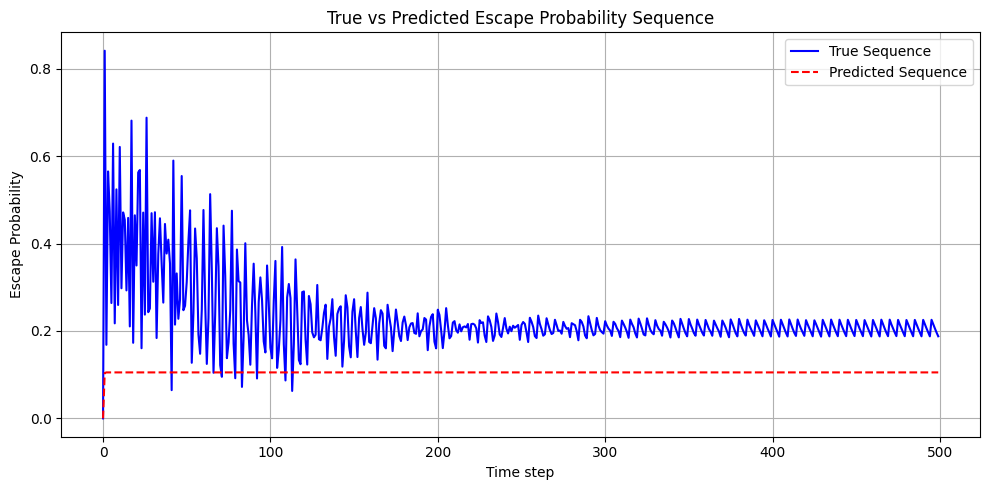

In [106]:
plt.figure(figsize=(10,5))
plt.plot(y_true, label="True Sequence", color='blue')
plt.plot(predicted_seq, label="Predicted Sequence", color='red', linestyle='--')
plt.xlabel("Time step")
plt.ylabel("Escape Probability")
plt.title("True vs Predicted Escape Probability Sequence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Full vector instead of RNN

In [113]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [115]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 256, 128), 
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

In [116]:
mlp.fit(X_train, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,2000
,shuffle,True


In [117]:
y_pred = mlp.predict(X_test)

# Compute R² score
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MLP Test R²: {r2:.4f}")
print(f"MLP Test RMSE: {rmse:.6f}")

MLP Test R²: -2719230.3492
MLP Test RMSE: 0.133652


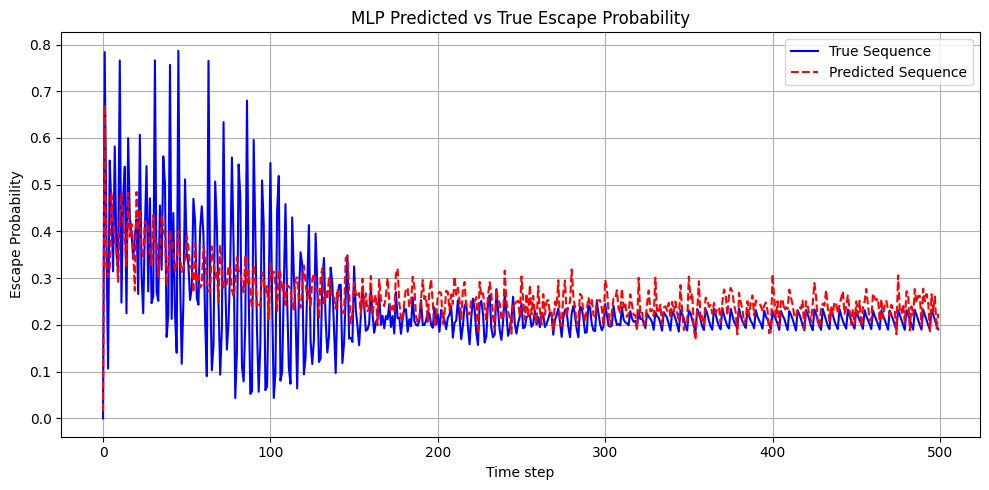

In [118]:
true_seq = y_test[0]
pred_seq = y_pred[0]

plt.figure(figsize=(10,5))
plt.plot(true_seq, label="True Sequence", color='blue')
plt.plot(pred_seq, label="Predicted Sequence", color='red', linestyle='--')
plt.xlabel("Time step")
plt.ylabel("Escape Probability")
plt.title("MLP Predicted vs True Escape Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Ensemble

In [125]:
y_combined = y[:, :200]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y_combined, test_size=0.2, random_state=42)

# --- Train Decision Tree for sequence (fit each output independently) ---
# Trick: DecisionTreeRegressor can predict multi-output directly
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)

# --- Train MLP ---
mlp = MLPRegressor(hidden_layer_sizes=(128,256,128), max_iter=2000, random_state=42)
mlp.fit(X_train, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,2000
,shuffle,True


In [128]:
# Predict with both models
y_pred_dt = dt.predict(X_test)
y_pred_mlp = mlp.predict(X_test)

# Average predictions
y_pred_ensemble = (y_pred_dt + y_pred_mlp) / 2


In [129]:
r2_dt = r2_score(y_test, y_pred_dt)
r2_mlp = r2_score(y_test, y_pred_mlp)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Decision Tree R²: {r2_dt:.4f}")
print(f"MLP R²: {r2_mlp:.4f}")
print(f"Ensemble R²: {r2_ensemble:.4f}")


Decision Tree R²: -0.5476
MLP R²: -324325.3622
Ensemble R²: -81081.4161


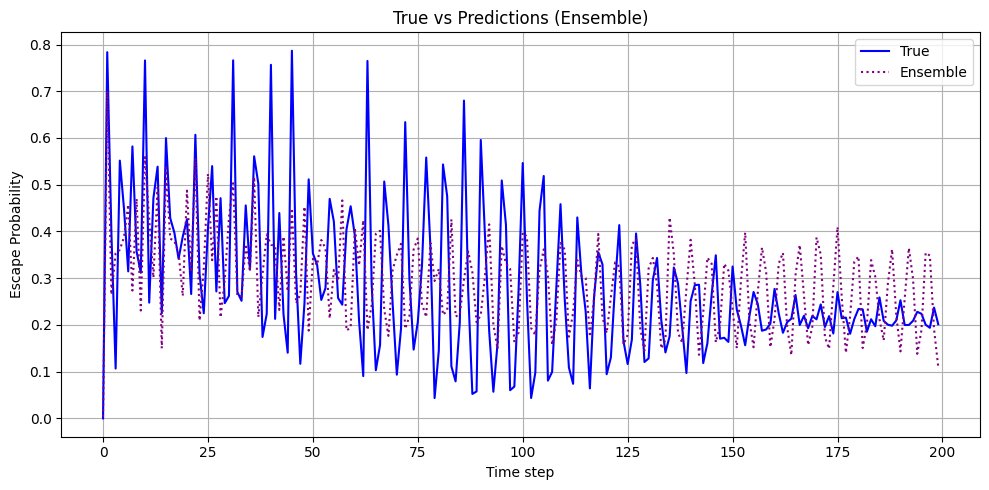

In [134]:
idx = 0  # first test sample
plt.figure(figsize=(10,5))
plt.plot(y_test[idx], label='True', color='blue')
# plt.plot(y_pred_dt[idx], label='Decision Tree', color='green', linestyle='--')
# plt.plot(y_pred_mlp[idx], label='MLP', color='red', linestyle='--')
plt.plot(y_pred_ensemble[idx], label='Ensemble', color='purple', linestyle=':')
plt.xlabel('Time step')
plt.ylabel('Escape Probability')
plt.title('True vs Predictions (Ensemble)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## PCA + (MLP, Decision Tree, Ensemble)

In [174]:
# y_pca = y[:, :200]
y_pca = y

In [175]:
y_pca.shape

(125, 500)

In [176]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_pca)  # scale each sequence to [0,1]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

In [177]:
pca = PCA(n_components=20)
y_pca = pca.fit_transform(y_scaled)

In [178]:
y_pca.shape

(125, 20)

In [179]:
X_train, X_test, y_train_pca, y_test_pca = train_test_split(X, y_pca, test_size=0.2, random_state=42)

In [180]:
mlp = MLPRegressor(hidden_layer_sizes=(128,256), max_iter=2000, random_state=42)
mlp.fit(X_train, y_train_pca)

,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,2000
,shuffle,True


In [181]:
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train_pca)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [182]:
# Predict PCA components
y_pred_mlp_pca = mlp.predict(X_test)
y_pred_dt_pca = dt.predict(X_test)

# Simple average ensemble
y_pred_ensemble_pca = (y_pred_mlp_pca + y_pred_dt_pca) / 2

# Inverse transform PCA to full 500-step sequences
y_pred_mlp_full = pca.inverse_transform(y_pred_mlp_pca)
y_pred_dt_full = pca.inverse_transform(y_pred_dt_pca)
y_pred_ensemble_full = pca.inverse_transform(y_pred_ensemble_pca)

# Inverse scale to original escape probability
y_pred_mlp_full = scaler_y.inverse_transform(y_pred_mlp_full)
y_pred_dt_full = scaler_y.inverse_transform(y_pred_dt_full)
y_pred_ensemble_full = scaler_y.inverse_transform(y_pred_ensemble_full)
y_test_full = scaler_y.inverse_transform(pca.inverse_transform(y_test_pca))


In [183]:
r2_mlp = r2_score(y_test_full, y_pred_mlp_full)
r2_dt = r2_score(y_test_full, y_pred_dt_full)
r2_ensemble = r2_score(y_test_full, y_pred_ensemble_full)

print(f"MLP R²: {r2_mlp:.4f}")
print(f"Decision Tree R²: {r2_dt:.4f}")
print(f"Ensemble R²: {r2_ensemble:.4f}")

MLP R²: 0.2096
Decision Tree R²: -0.4536
Ensemble R²: 0.0491


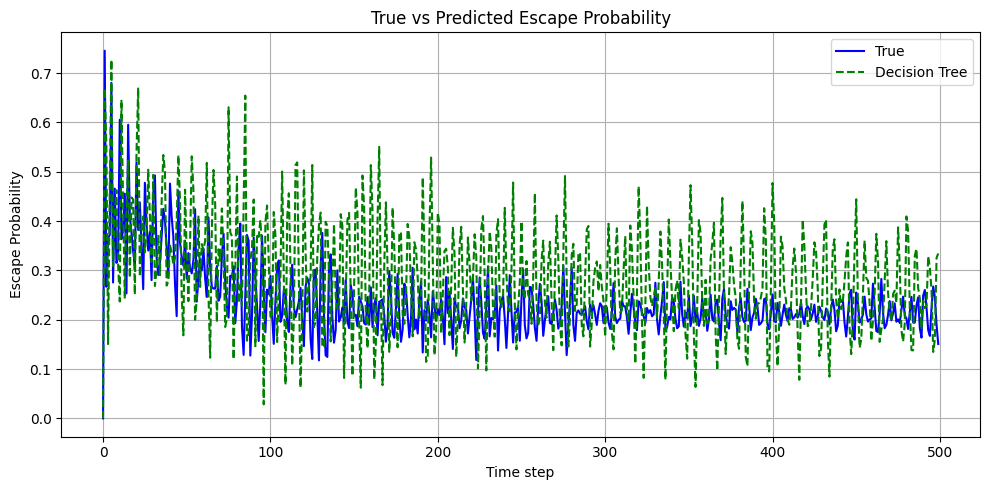

In [185]:
import matplotlib.pyplot as plt

idx = 0  # first test sample
plt.figure(figsize=(10,5))
plt.plot(y_test_full[idx], label='True', color='blue')
# plt.plot(y_pca[idx], label='PCA', color='black', linestyle='--')
# plt.plot(y_pred_mlp_full[idx], label='MLP', color='red', linestyle='--')
plt.plot(y_pred_dt_full[idx], label='Decision Tree', color='green', linestyle='--')
# plt.plot(y_pred_ensemble_full[idx], label='Ensemble', color='purple', linestyle=':')
plt.xlabel('Time step')
plt.ylabel('Escape Probability')
plt.title('True vs Predicted Escape Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


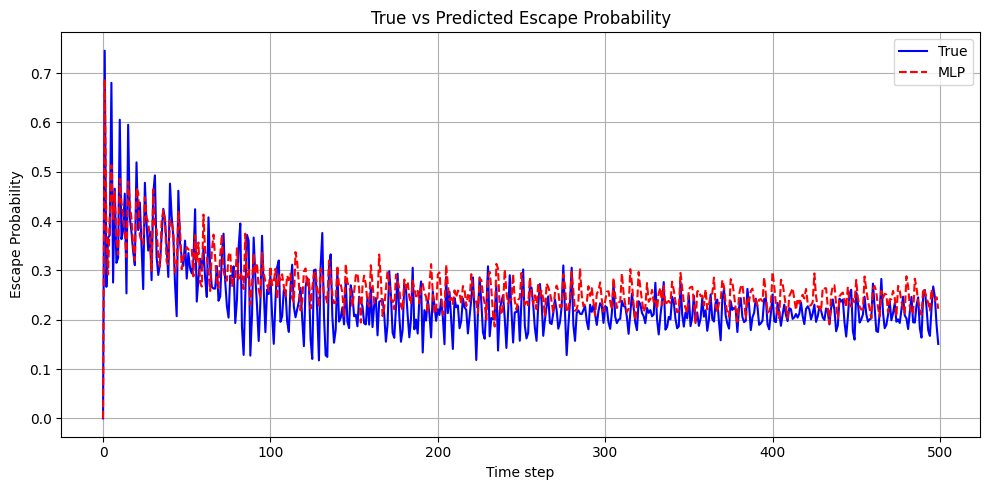

In [186]:
import matplotlib.pyplot as plt

idx = 0  # first test sample
plt.figure(figsize=(10,5))
plt.plot(y_test_full[idx], label='True', color='blue')
# plt.plot(y_pca[idx], label='PCA', color='black', linestyle='--')
plt.plot(y_pred_mlp_full[idx], label='MLP', color='red', linestyle='--')
# plt.plot(y_pred_dt_full[idx], label='Decision Tree', color='green', linestyle='--')
# plt.plot(y_pred_ensemble_full[idx], label='Ensemble', color='purple', linestyle=':')
plt.xlabel('Time step')
plt.ylabel('Escape Probability')
plt.title('True vs Predicted Escape Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
